### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [1]:
# Install required libs

# ### please update Albumentations to version>=0.3.0 for `Lambda` trans`form support
# !pip3 install -U albumentations>=0.3.0 --user 
# !pip3 install -U --pre segmentation-models --user

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import time

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.
/home/ruslan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ruslan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ruslan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ruslan/.local/lib/python3.6/site-packages/tensorflow/python

# Loading dataset

In [3]:
DATA_DIR = './sidewalk_dataset/'

x_train_dir = os.path.join(DATA_DIR, 'images/train/')
y_train_dir = os.path.join(DATA_DIR, 'labels/train/')

x_valid_dir = os.path.join(DATA_DIR, 'images/val/')
y_valid_dir = os.path.join(DATA_DIR, 'labels/val/')

# DATA_DIR = '/home/ruslan/Desktop/road_dataset/data/'

# x_train_dir = os.path.join(DATA_DIR, 'JPEGImages')
# y_train_dir = os.path.join(DATA_DIR, 'SegmentationClassPNG')

# x_valid_dir = os.path.join(DATA_DIR, 'JPEGImages')
# y_valid_dir = os.path.join(DATA_DIR, 'SegmentationClassPNG')

# Dataloader and utility functions 

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['road']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.get_y_fn = lambda x: f'{Path(x).stem}.png'
        
        self.ids = os.listdir(images_dir)
        self.mask_ids = [self.get_y_fn(iD) for iD in self.ids]
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.mask_ids]
        
        # convert str names to class values on masks
        self.class_values = [38.] #[self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

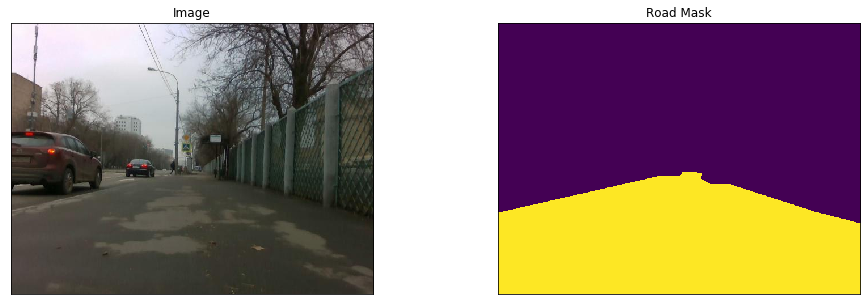

In [5]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['road'])

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    road_mask=mask[..., 0].squeeze(),
)

#### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [6]:
import albumentations as A

size = (192, 320)

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [
        A.Resize(size[0], size[1], interpolation=1, always_apply=True), #cv2.INTER_LINEAR
        
        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=size[0], min_width=size[1], always_apply=True, border_mode=0),
#         A.RandomCrop(height=size[0], width=size[1], always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.Resize(size[0], size[1], interpolation=1, always_apply=True) #cv2.INTER_LINEAR
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

/home/ruslan/.local/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2875: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


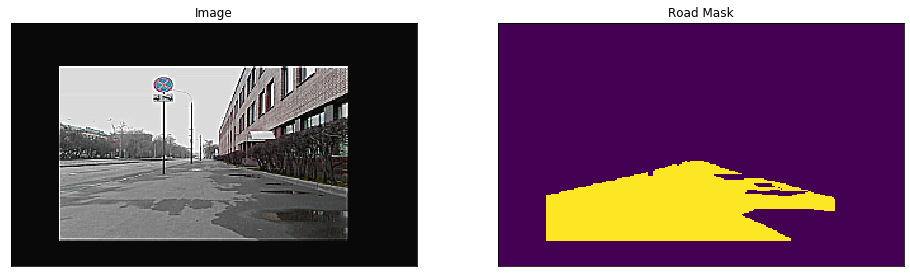

In [7]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['road'], augmentation=get_training_augmentation())

image, mask = dataset[102] # get some sample
visualize(
    image=image, 
    road_mask=mask[..., 0].squeeze(),
)

# Segmentation model transfer learning

In [8]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [9]:
BACKBONE = 'resnet18'
BATCH_SIZE = 8
CLASSES = ['road']
LR = 1e-4
EPOCHS = 20

preprocess_input = sm.get_preprocessing(BACKBONE)

In [10]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [11]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1.0])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

### Load model trained on Berkeley Deep Drive drivable area segmantation dataset

In [12]:
model.load_weights('trained_models/unet-resnet18-berkeley-drivable-192x320.h5')

Fine-tuning the model on custom dataset

In [13]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 192, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 192, 320, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [14]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/20
14/14 [==============================] - 6s 399ms/step - loss: 0.3089 - iou_score: 0.8569 - f1-score: 0.9213 - val_loss: 0.0964 - val_iou_score: 0.9509 - val_f1-score: 0.9745
Epoch 2/20
14/14 [==============================] - 1s 79ms/step - loss: 0.1945 - iou_score: 0.9205 - f1-score: 0.9585 - val_loss: 0.1085 - val_iou_score: 0.9581 - val_f1-score: 0.9783
Epoch 3/20
14/14 [==============================] - 1s 82ms/step - loss: 0.1738 - iou_score: 0.9284 - f1-score: 0.9628 - val_loss: 0.1107 - val_iou_score: 0.9631 - val_f1-score: 0.9809
Epoch 4/20
14/14 [==============================] - 1s 79ms/step - loss: 0.1712 - iou_score: 0.9299 - f1-score: 0.9635 - val_loss: 0.1057 - val_iou_score: 0.9645 - val_f1-score: 0.9817
Epoch 5/20
14/14 [==============================] - 1s 83ms/step - loss: 0.1498 - iou_score: 0.9390 - f1-score: 0.9685 - val_loss: 0.1019 - val_iou_score: 0.9653 - 

# Model Evaluation

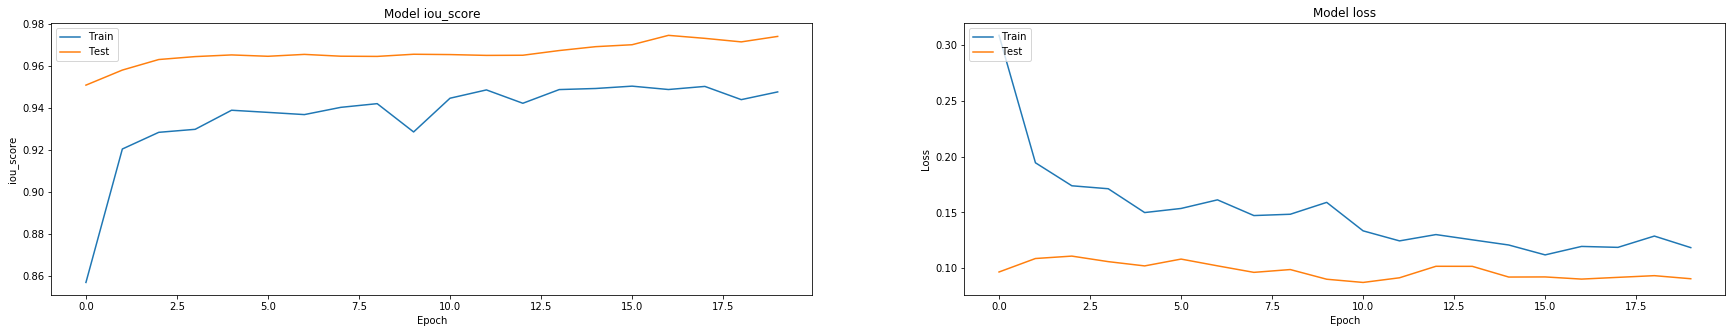

In [15]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
# load best weights
model.load_weights('best_model.h5')

In [20]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.11788
mean iou_score: 0.94814
mean f1-score: 0.97335


# Visualization of results on test dataset

Time for forward pass: 0.021687984466552734


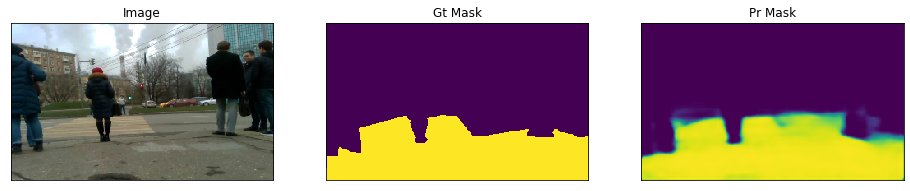

Time for forward pass: 0.007653474807739258


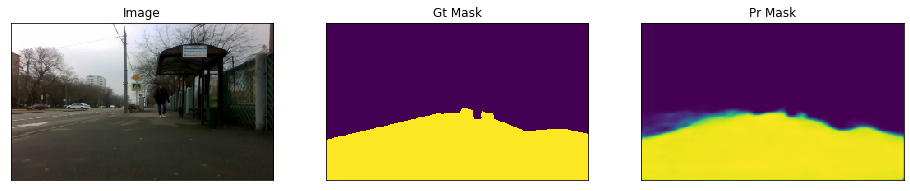

Time for forward pass: 0.007441520690917969


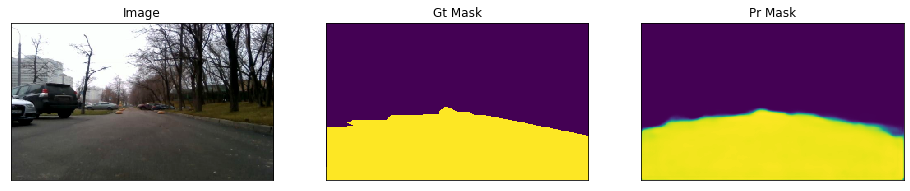

Time for forward pass: 0.007561683654785156


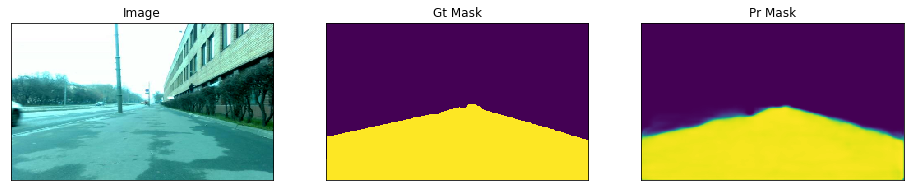

Time for forward pass: 0.007561922073364258


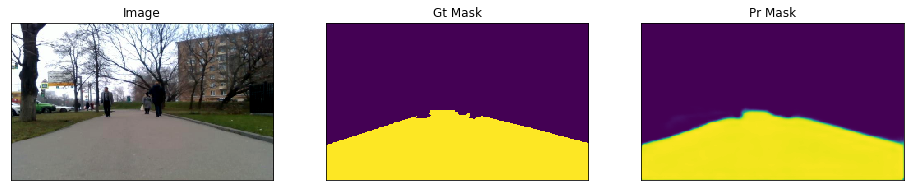

Time for forward pass: 0.007447719573974609


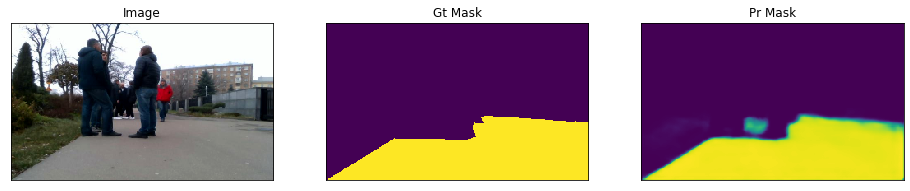

Time for forward pass: 0.007558584213256836


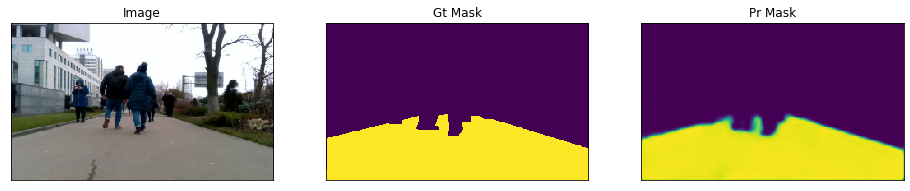

Time for forward pass: 0.0075778961181640625


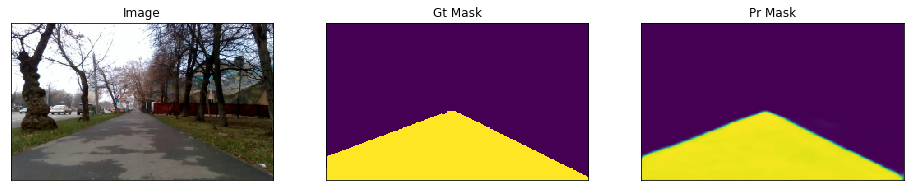

Time for forward pass: 0.007486820220947266


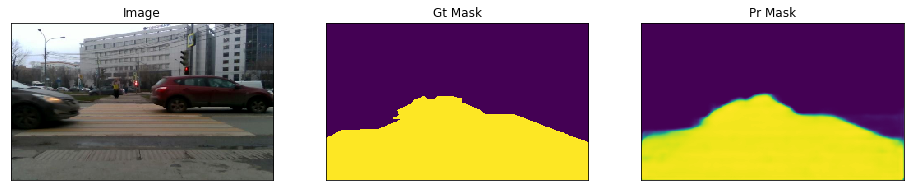

Time for forward pass: 0.0075261592864990234


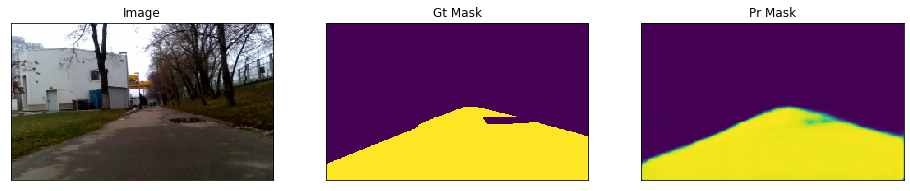

In [22]:
ids = np.arange(len(valid_dataset))

for i in ids:
    
    image, gt_mask = valid_dataset[i]
    image = np.expand_dims(image, axis=0)
    start = time.time()
    pr_mask = model.predict(image)
    end = time.time()
    print('Time for forward pass:', end-start)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )

## Test on video stream

In [23]:
def pred2seg_result(seg_mask, image):
    # Generate fake R & B color dimensions, stack with G
    size = (seg_mask.shape[:2])
    blanks = np.zeros(size).astype(np.uint8)
    lane_drawn = np.dstack((blanks, seg_mask, blanks))

    # # Re-size to match the original image
    lane_image = cv2.resize(lane_drawn, (image.shape[1], image.shape[0]))

    # Merge the lane drawing onto the original image
    result = 0.7* denormalize(image) + 0.3 * lane_image
    return denormalize(result)

In [ ]:
import imutils
from tqdm import tqdm

PATH_TO_VIDEO = '/home/ruslan/Desktop/SelfDrivingCar/robot_scene_understanding/Semantic_Segmentation/Tensorflow_Deeplab_ModelZoo/way_back.avi'
vs = cv2.VideoCapture(PATH_TO_VIDEO)
writer = None

# try to determine the total number of frames in the video file
try:
    prop =  cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
        else cv2.CAP_PROP_FRAME_COUNT
    total = int(vs.get(prop))
    print("[INFO] {} total frames in video".format(total))
# an error occurred while trying to determine the total
# number of frames in the video file
except:
    print("[INFO] could not determine # of frames in video")
    total = -1

FPS = []
while(1):
# for i in tqdm( range(50) ):
    # get raw frames from video stream
    ret, frame_raw = vs.read()
    if ret == False:
        break
    # preprocess raw frames
    start = time.time()
    frame = preprocess_input(frame_raw)
    frame = np.expand_dims(frame, axis=0)
    # predict segmentation mask from the frame
    pr_mask = model.predict(frame)
    end = time.time()
    dt = end-start
    FPS.append(1./dt)
    pr_mask = denormalize(pr_mask.squeeze())
    output_to_write = np.uint8( pred2seg_result(pr_mask, frame_raw)*255 )
    # print("[INFO] single frame took {:.4f} seconds".format(dt))
    
    # check if the video writer is None
    if writer is None:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter('output.avi', fourcc, 30, (640, 480), True)

        # some information on processing single frame
        if total > 0:
            elap = (end - start)
            print("[INFO] single frame took {:.4f} seconds".format(elap))
            print("[INFO] estimated total time: {:.4f} [min]".format(elap * total/60.))

    # write the output frame to disk    
    writer.write(output_to_write) # should be of shape (h x w x 3), type=np.uint8 (0..255)
    
#     visualize(
#         image=denormalize(frame.squeeze()[:,:,(2,1,0)]),
#         pr_mask=pr_mask.squeeze(),
#         seg_output=output_to_write,
#     )

print("[INFO] Mean FPS {:.4f} Hz".format(np.mean(FPS)))


[INFO] 17297 total frames in video
[INFO] single frame took 0.5386 seconds
[INFO] estimated total time: 155.2657 [min]
